**BA810 Cohort B Team 2:** Ahmed Farid Khan, Jessica Tong, Riya Gupta, Shayan Hasan

# NYC Property Prices

## 1- Data Source & Problem Definition

This data is retrieved from [Kaggle](https://www.kaggle.com/datasets/new-york-city/nyc-property-sales), which compiled lists of rolling sales data in the five boroughs of NYC [here](https://www.nyc.gov/site/finance/taxes/property-rolling-sales-data.page). This dataset contains the location, address, type, sale price, and sale date of building units sold.


Historically, New York City has been one of the most expensive real estate markets in the United
States. The state of purchasing property in New York City in the modern day is competitive and
complex due to a variety of factors. These factors include high market demand, low inventory levels,
the necessity of high financial requirements, and tax considerations. Therefore, we aspire to
generate a Property Sale Price Prediction model to solve the issue of uncertainty regarding the
estimation of sale prices for properties in New York City based on a particular property’s
characteristics. This prediction model will allow for a data-driven approach to estimate property sales
prices while considering a wide range of variables including the location, square footage, and
apartment size, etc.

### 1.1 Data Dictionary

* **BOROUGH**: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

* **NEIGHBORHOOD**: The area in which the address is located.

* **BLOCK; LOT**: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a **BBL**.

* **BUILDING CLASS AT PRESENT** and **BUILDING CLASS AT TIME OF SALE**: The type of building at various points in time. See the glossary linked to below.

* **TAX CLASS AT PRESENT** and **TAX CLASS AT TIME OF SALE**: The tax class of building at various points in time.

* **EASEMENT**: Right of way which allows an entity to make limited use of another's property.

* **ADDRESS**: Street Address of the property.

* **APARTMENT NUMBER**:

* **ZIP CODE**: Property's postal code.

* **RESIDENTIAL UNITS**: The number of residential units at the listed property.

* **COMMERCIAL UNITS**: The number of commercial units at the listed property.

* **TOTAL UNITS**: The total number of units at the listed property.

* **LAND SQUARE FEET**: The land area of the property listed in square feet.

* **GROSS SQUARE FEET**: The total area of all the floors of a building as measured from the exterior surfaces of the
outside walls of the building, including the land area and space within any building or structure
on the property.

* **YEAR BUILT**: Year the structure on the property was built.

* **SALE PRICE**: Price paid for the property.

* **SALE DATE**: Date the property sold.

*For further reference on individual fields see the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf). For the building classification codes see the [Building Classifications Glossary](https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html).*

## 2- Initial Exploration

The dataset includes **84,548** records and **22** columns.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.

This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.

In [1]:
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint

# Import necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv # needed to enable Halving features
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
import pandas as pd
nyc = pd.read_csv('https://raw.githubusercontent.com/eshentong/BA810-team-project/main/nyc-rolling-sales.csv')

In [3]:
print(nyc.shape)
nyc.head(3)

(84548, 22)


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00


### Dropping First Column

The first column is unnamed.

These values appear to have been used to iterate through each borough's properties. We will simply drop this column.

In [4]:
nyc.drop(columns={nyc.columns[0]}, inplace=True)

### EASE-MENT column
Dropping empty column `EASE-MENT`

In [5]:
nyc['EASE-MENT'].unique()

array([' '], dtype=object)

In [6]:
nyc.drop(columns={'EASE-MENT'}, inplace=True)

### Setting the right dtypes

In [7]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       84548 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                84548 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

In [8]:
# Converting to categorical columns
col_to_cat = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']
for col in col_to_cat:
   nyc[col] = nyc[col].astype('category')

In [9]:
# Converting to numerical columns
col_to_numeric = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE', 'YEAR BUILT']
for col in col_to_numeric:
  nyc[col] = pd.to_numeric(nyc[col], errors='coerce')

In [10]:
nyc['LAND SQUARE FEET'].value_counts()

0.0        10326
2000.0      3919
2500.0      3470
4000.0      3044
1800.0      1192
           ...  
5886.0         1
76712.0        1
6777.0         1
10833.0        1
10796.0        1
Name: LAND SQUARE FEET, Length: 6061, dtype: int64

In [11]:
# Converting to datetime column
nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])

In [12]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING CLASS CATEGORY         84548 non-null  category      
 3   TAX CLASS AT PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING CLASS AT PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT NUMBER                84548 non-null  object        
 9   ZIP CODE                        84548 non-null  category      
 10  RESIDENTIAL UNITS               84548 non-null  int64         
 11  CO

### Missing Values Exploration

According to .info(), there are missing values in the following columns: **LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE**

We also know from manual observation that there are some missing values in the following columns: **APARTMENT NUMBER**

In [13]:
print('% missing for LAND SQUARE FEET:', round(nyc['LAND SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for GROSS SQUARE FEET:', round(nyc['GROSS SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for SALE PRICE:', round(nyc['SALE PRICE'].isna().sum()/nyc.shape[0], 2))

% missing for LAND SQUARE FEET: 0.31
% missing for GROSS SQUARE FEET: 0.33
% missing for SALE PRICE: 0.17


In [14]:
nyc['SALE PRICE'].value_counts()

0.0          10228
10.0           766
450000.0       427
550000.0       416
650000.0       414
             ...  
191100.0         1
811000.0         1
782990.0         1
2784765.0        1
69300.0          1
Name: SALE PRICE, Length: 10007, dtype: int64

Apart from the missing values in 'SALE PRICE' column, there are also 10994 values in the column which the value equals either 0 (10228) or 10 (766).

In [15]:
nyc['APARTMENT NUMBER'].value_counts()

        65496
4         298
3A        295
2         275
3B        275
        ...  
ST50        1
ST54        1
SU13        1
SU21        1
363         1
Name: APARTMENT NUMBER, Length: 3989, dtype: int64

For Apartment Number, there are 65496 empty columns. We will assume that these are empty since this is the sale of a whole building rather than an apartment.

### Standardizing column names




- Removing spaces in naming convention

In [16]:
nyc.columns = nyc.columns.str.replace(' ', '_')

### Summary Statistics

In [17]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

nyc.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
count,84548.00,84548.00,84548.00,58296.00,56936.00,84548.00,69987.00
mean,2.03,0.19,2.25,3941.68,4045.71,1789.32,1276456.50
std,16.72,8.71,18.97,41983.97,35032.49,537.34,11405255.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,1650.00,1046.75,1920.00,225000.00
50%,1.00,0.00,1.00,2325.00,1680.00,1940.00,530000.00
75%,2.00,0.00,2.00,3500.00,2560.00,1965.00,950000.00
max,1844.00,2261.00,2261.00,4252327.00,3750565.00,2017.00,2210000000.00


In [18]:
nyc.describe(include=['category', 'object'])

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
count,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548
unique,5,254,47,11,11566,2627,167,67563,3989,186,4,166
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,5066,1,D4,131-05 40TH ROAD,,10314,1,R4
freq,26736,3068,18235,38633,404,4125,12663,210,65496,1687,41533,12989


In [19]:
nyc.describe(include = 'datetime')

<ipython-input-19-2e89c4609a0d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nyc.describe(include = 'datetime')


,SALE_DATE
count,84548
unique,364
top,2017-06-29 00:00:00
freq,544
first,2016-09-01 00:00:00
last,2017-08-31 00:00:00


##3- Data Cleaning

- ADD MARKUP -------

In [20]:
# Creating a duplicate of the dataset for convenience
nyc_copy=nyc.copy()

In [21]:
# Displaying index of columns
temp = pd.DataFrame(index=nyc_copy.columns)
temp

""
BOROUGH
NEIGHBORHOOD
BUILDING_CLASS_CATEGORY
TAX_CLASS_AT_PRESENT
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT
ADDRESS
APARTMENT_NUMBER
ZIP_CODE


### Checking for null values

In [22]:
def nyc_df_info():
    temp = pd.DataFrame(index=nyc_copy.columns)
    temp["Datatype"] = nyc_copy.dtypes
    temp["Not null values"] = nyc_copy.count()
    temp["Null values"] = nyc_copy.isnull().sum()
    temp["Percentage of Null values"] = (nyc_copy.isnull().mean())*100
    temp["Unique count"] = nyc_copy.nunique()
    return temp
nyc_df_info()

,Datatype,Not null values,Null values,Percentage of Null values,Unique count
BOROUGH,category,84548,0,0.00,5
NEIGHBORHOOD,category,84548,0,0.00,254
BUILDING_CLASS_CATEGORY,category,84548,0,0.00,47
TAX_CLASS_AT_PRESENT,category,84548,0,0.00,11
BLOCK,category,84548,0,0.00,11566
LOT,category,84548,0,0.00,2627
BUILDING_CLASS_AT_PRESENT,category,84548,0,0.00,167
ADDRESS,object,84548,0,0.00,67563
APARTMENT_NUMBER,object,84548,0,0.00,3989
ZIP_CODE,category,84548,0,0.00,186


In [23]:
nyc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING_CLASS_CATEGORY         84548 non-null  category      
 3   TAX_CLASS_AT_PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING_CLASS_AT_PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT_NUMBER                84548 non-null  object        
 9   ZIP_CODE                        84548 non-null  category      
 10  RESIDENTIAL_UNITS               84548 non-null  int64         
 11  CO

In [24]:
nyc_copy['LAND_SQUARE_FEET'].value_counts()

0.00        10326
2000.00      3919
2500.00      3470
4000.00      3044
1800.00      1192
            ...  
5886.00         1
76712.00        1
6777.00         1
10833.00        1
10796.00        1
Name: LAND_SQUARE_FEET, Length: 6061, dtype: int64

### Dropping Columns

####BOROUGH - NEIGHBORHOOD ASSOCIATION

CRAMER'S V:
- It is a measure of association between categorical variables. It quantifies the strength of association between two categorical variables, ranging from 0 to 1, where 0 indicates no association, and 1 represents a strong association.
- This tells us that both the columns **BOROUGH** and **NEIGHBOURHOOD** are very strongly associated so we will choose to drop one of them

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming df is your DataFrame with 'Borough' and 'Neighborhood' columns
contingency_table = pd.crosstab(nyc_copy['BOROUGH'], nyc_copy['NEIGHBORHOOD'])

# Chi-squared test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 337442.1126549097
P-value: 0.0


In [26]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_value = cramers_v(contingency_table.values)
print(f"Cramér's V value: {cramers_v_value}")

Cramér's V value: 0.9974153128138344


####BOROUGH - ZIP_CODE ASSOCIATION

- This tells us that both the columns **BOROUGH** and **ZIP CODE** are very strongly associated so we will choose to drop one of them.

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming df is your DataFrame with 'Borough' and 'Neighborhood' columns
contingency_table = pd.crosstab(nyc_copy['BOROUGH'], nyc_copy['ZIP_CODE'])

# Chi-squared test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 333574.3797433641
P-value: 0.0


In [28]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_value = cramers_v(contingency_table.values)
print(f"Cramér's V value: {cramers_v_value}")

Cramér's V value: 0.9920708589906893


Cramer's V scores show that there are high associations between **BOROUGH** and **ZIP CODE**, as well as **BOROUGH** and **NEIGHBORHOOD**. so we will be dropping `ZIP CODE` and `NEIGHBORHOOD`.

#### DROPPING CHOSEN COLUMNS

Dropping irrelevant columns:
- `ADDRESS`, `BLOCK`, `LOT`, `APARTMENT_NUMBER``BUILDING_CLASS_AT_TIME_OF_SALE`, `TAX_CLASS_AT_PRESENT`, `BUILDING_CLASS_AT_PRESENT`, `NEIGHBORHOOD`, `ZIP_CODE`, `SALE_DATE`

In [29]:
#due to one-hard encoding, these cols are too granular
columns_to_drop = ['ADDRESS', 'BLOCK', 'LOT', 'APARTMENT_NUMBER','BUILDING_CLASS_CATEGORY',
                   'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'NEIGHBORHOOD', 'ZIP_CODE',
                   'SALE_DATE']
nyc_copy.drop(columns=columns_to_drop, inplace=True)
nyc_copy

,BOROUGH,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
0,1,5,0,5,1633.00,6440.00,1900,2,C2,6625000.00
1,1,28,3,31,4616.00,18690.00,1900,2,C7,NaN
2,1,16,1,17,2212.00,7803.00,1900,2,C7,NaN
3,1,10,0,10,2272.00,6794.00,1913,2,C4,3936272.00
4,1,6,0,6,2369.00,4615.00,1900,2,C2,8000000.00
...,...,...,...,...,...,...,...,...,...,...
84543,5,2,0,2,2400.00,2575.00,1998,1,B9,450000.00
84544,5,2,0,2,2498.00,2377.00,1998,1,B9,550000.00
84545,5,2,0,2,4000.00,1496.00,1925,1,B2,460000.00
84546,5,0,7,7,208033.00,64117.00,2001,4,K6,11693337.00


In [30]:
nyc_copy.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
count,84548.00,84548.00,84548.00,58296.00,56936.00,84548.00,69987.00
mean,2.03,0.19,2.25,3941.68,4045.71,1789.32,1276456.50
std,16.72,8.71,18.97,41983.97,35032.49,537.34,11405255.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,1650.00,1046.75,1920.00,225000.00
50%,1.00,0.00,1.00,2325.00,1680.00,1940.00,530000.00
75%,2.00,0.00,2.00,3500.00,2560.00,1965.00,950000.00
max,1844.00,2261.00,2261.00,4252327.00,3750565.00,2017.00,2210000000.00


### Dropping Outliers

- Eliminating SALE PRICE values below 10,000 and above 5,000,000 to focus on typical property sale prices.

- Dropping rows with missing values in the LAND SQUARE FEET column for data completeness.

- Removing properties with land sizes exceeding 50,000 square feet for analysis focusing on standard sizes.

- Eliminating properties with sizes exceeding 50,000 square feet for a more focused analysis.

- Eliminating outlier 2261 from the GROSS SQUARE FEET column due to significant deviation.

- Removing outlier 2261 from the TOTAL UNITS column, likely an abnormal entry.

- Eliminating outlier 1844 from the LAND SQUARE FEET column due to substantial deviation.



In [31]:
#dropping empty, 0, very low or outlier sales price rows
nyc_copy = nyc_copy[(nyc_copy['SALE_PRICE'] > 10000) & (nyc_copy['SALE_PRICE'].notna()) & (nyc_copy['SALE_PRICE'] < 5000000)]

#dropping outlier LAND_SQUARE_FEET
nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder

nyc_copy = nyc_copy[(nyc_copy['LAND_SQUARE_FEET'] > 0) & (nyc_copy['LAND_SQUARE_FEET'] < 50000)]

nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].replace(1, np.nan)

#dropping outlier GROSS_SQUARE_FEET
nyc_copy['GROSS_SQUARE_FEET'] = nyc_copy['GROSS_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder

nyc_copy = nyc_copy[(nyc_copy['GROSS_SQUARE_FEET'] > 0) & (nyc_copy['GROSS_SQUARE_FEET'] < 50000)]

nyc_copy['GROSS_SQUARE_FEET'] = nyc_copy['GROSS_SQUARE_FEET'].replace(1, np.nan)

#dropping total units
nyc_copy = nyc_copy[(nyc_copy['TOTAL_UNITS'] != 0) & (nyc_copy['TOTAL_UNITS'] != 2261)]

#dropping commercial units
nyc_copy = nyc_copy[nyc_copy['COMMERCIAL_UNITS'] != 2261]

#dropping residential units
nyc_copy = nyc_copy[nyc_copy['RESIDENTIAL_UNITS'] != 1844]

nyc_copy = nyc_copy.drop_duplicates()

<ipython-input-31-dd7e59b070f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder


In [32]:
nyc_copy.head()

,BOROUGH,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
3,1,10,0,10,2272.00,6794.00,1913,2,C4,3936272.00
6,1,8,0,8,1750.00,4226.00,1920,2,C4,3192840.00
76,1,1,0,1,NaN,NaN,0,2,R2,620000.00
79,1,1,0,1,NaN,NaN,1920,2,R4,762669.00
80,1,1,0,1,NaN,NaN,1920,2,R4,772851.00


## 4- Data Visualizations

### Price Distribution

<Figure size 3000x1000 with 0 Axes>

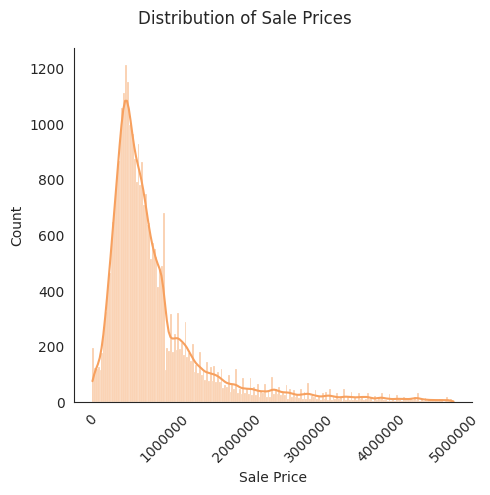

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_palette("Oranges_d")
plt.figure(figsize=(30, 10))

dplot = sns.displot(data=nyc_copy, x='SALE_PRICE', bins=200, kde=True, kde_kws={'bw_adjust': 0.5})

dplot.set_axis_labels("Sale Price", "Count")
dplot.fig.suptitle("Distribution of Sale Prices")
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show();

This graph tell us the Distribution of Sale Prices. It tells us that most of the houses are priced around 500k and that the trend decreases sharply after that.

### Boxplot of Gross Square Footage

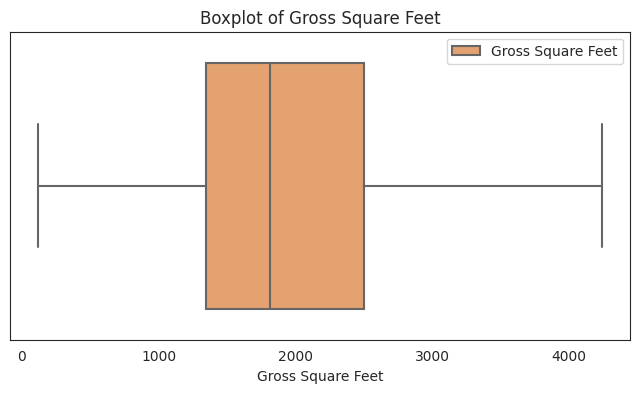

In [34]:
# Boxplot of Gross Square Footage
plt.figure(figsize=(8,4))
sns.boxplot(x='GROSS_SQUARE_FEET', data=nyc_copy ,showfliers=False)
# Adding legend, x-axis title, and y-axis title
plt.legend(labels=['Gross Square Feet'])
plt.xlabel('Gross Square Feet')
# plt.ylabel('Y-axis Title')
plt.title("Boxplot of Gross Square Feet")
plt.show()

This tells us the mean and inter-quartile range of the GROSS SQUARE FEET column

### Scatterplot of Gross Square Feet vs Price

Text(0.5, 1.0, 'Sale Price vs Gross Square Feet')

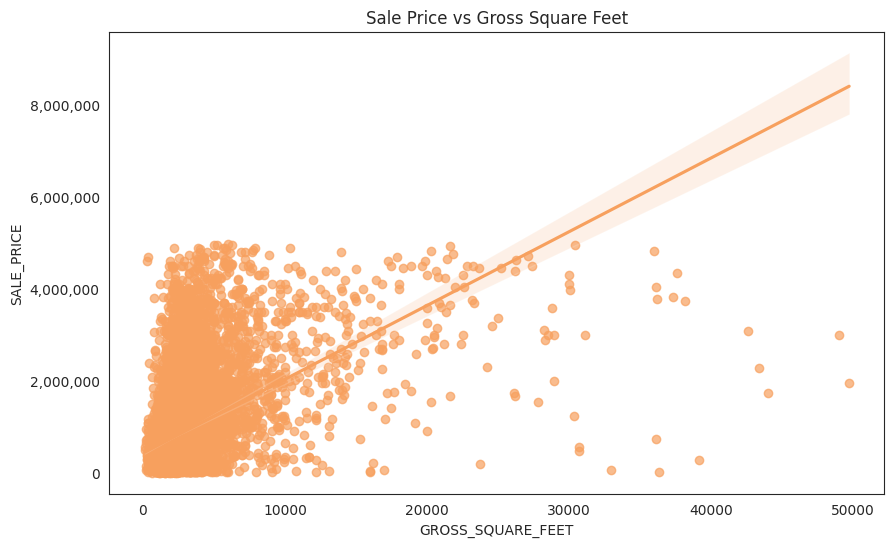

In [35]:
from matplotlib import ticker
# Scatter plot of Gross Square Footage
plt.figure(figsize=(10,6))
ax = sns.regplot(x='GROSS_SQUARE_FEET', y='SALE_PRICE', data=nyc_copy, scatter_kws={'alpha': 0.7})
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
plt.title('Sale Price vs Gross Square Feet')

This graph tell us the relationship between SALE PRICE and GROSS SQUARE FEET. This demonstrates a linear relationship.

### Boxplot of Land Square Footage

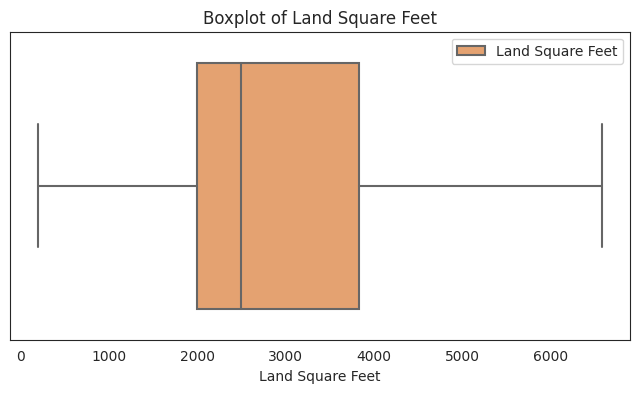

In [36]:
# Boxplot of Land Square Footage
plt.figure(figsize=(8,4))
sns.boxplot(x='LAND_SQUARE_FEET', data=nyc_copy ,showfliers=False)
# Adding legend, x-axis title, and y-axis title
plt.legend(labels=['Land Square Feet'])
plt.xlabel('Land Square Feet')
# plt.ylabel('Y-axis Title')
plt.title("Boxplot of Land Square Feet")
plt.show()

This tells us the mean and inter-quartile range of the GROSS SQUARE FEET column

### Scatterplot of Land Square Feet vs Sale Price

Text(0.5, 1.0, 'Land Square Feet Against Sale Price')

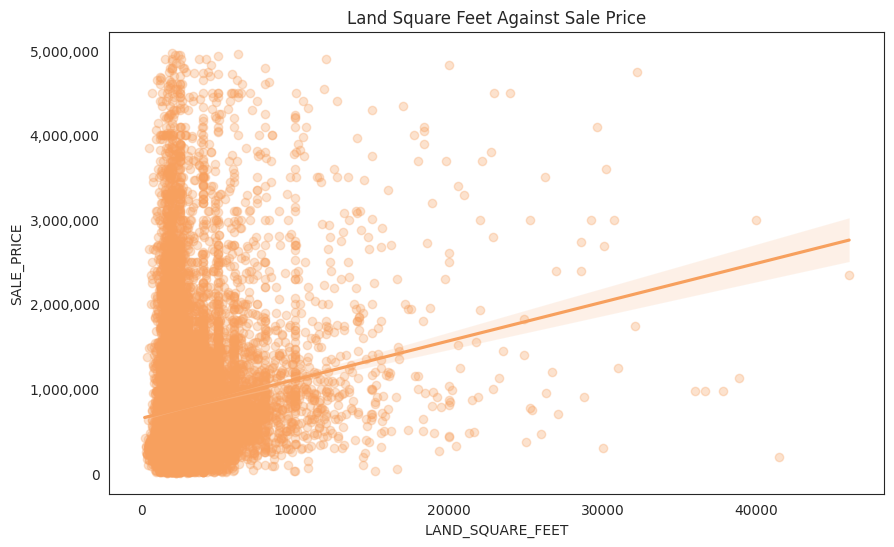

In [37]:
# Scatterplot of Price vs Land Square Footage
plt.figure(figsize=(10,6))
ax = sns.regplot(x='LAND_SQUARE_FEET', y='SALE_PRICE', data=nyc_copy, fit_reg=True, scatter_kws={'alpha':0.3})
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
plt.title('Land Square Feet Against Sale Price')

This graph tell us the relationship between SALE PRICE and LAND SQUARE FEET. This demonstrates a linear relationship.

### Price by Borough

<Figure size 800x600 with 0 Axes>

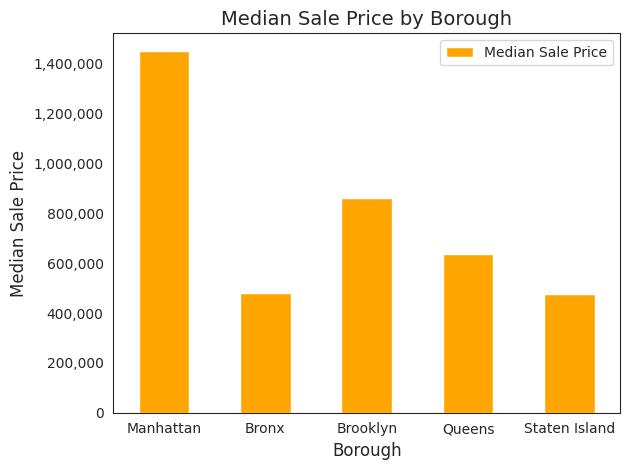

In [38]:
# Assuming 'custom_labels' is a list of custom labels for the boroughs
custom_labels = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
# Creating the pivot table without specifying custom index labels
pivot = nyc_copy.pivot_table(index='BOROUGH', values='SALE_PRICE', aggfunc=np.median)
# Creating the bar plot
plt.figure(figsize=(8, 6))
ax = pivot.plot(kind='bar', color='orange')
# Adding labels and titles
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Median Sale Price', fontsize=12)  # Y-label remains unchanged
plt.title('Median Sale Price by Borough', fontsize=14)
plt.legend(['Median Sale Price'], fontsize=10)
# Customizing x-axis tick labels with custom entries
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0)
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
# Displaying the plot
plt.tight_layout()
plt.show()


This graph tells us that from all the borough in our dataset, the median sale price of Manhattan is the highest, followed by Brooklyn then Queens, then Staten Island and finally Bronx

### Sale Price vs Total Units

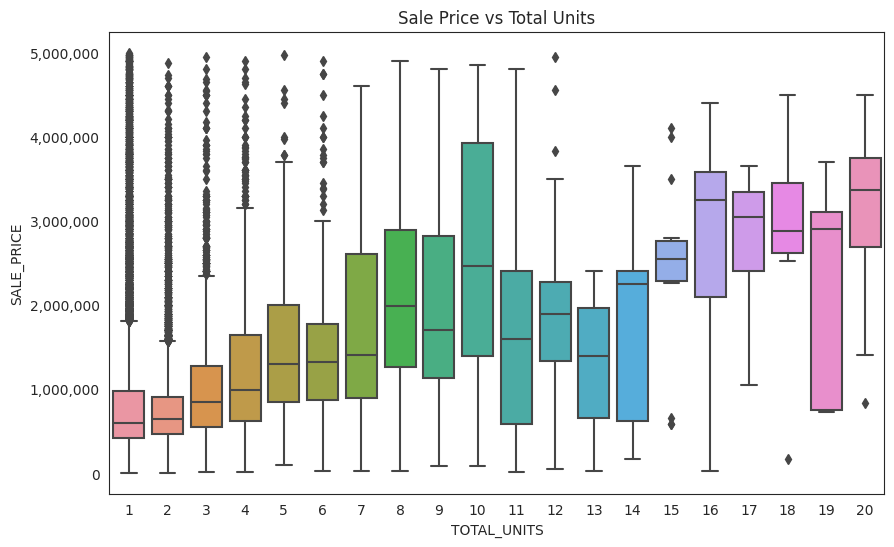

In [39]:
plot = nyc_copy[nyc_copy['TOTAL_UNITS'] <= 20]


plt.figure(figsize=(10,6))
ax = sns.boxplot(x='TOTAL_UNITS', y='SALE_PRICE', data=plot)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
plt.title('Sale Price vs Total Units')
plt.show()

This gives the boxplot for the Sale Price for the first 20 values in the Total Units column. This tell us that the price steadily increases as the number of units increases.

##5- Modeling

### Splitting Dataset

In [40]:
X = nyc_copy.drop(columns = ['SALE_PRICE'])
y = nyc_copy['SALE_PRICE']

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing Pipeline

This pipeline sequentially handles numerical and categorical columns by first addressing missing values (imputation) and then transforms the data to prepare it for further analysis.
1. Numerical Column Processing:

 - Imputation: Fill missing values in numerical columns with the median value.
 - Standardization: Standardize the numerical columns to have a mean of 0 and a standard deviation of 1.

2. Categorical Column Processing:

 - Imputation: Fill missing values in categorical columns with the most frequent value.
 - One-Hot Encoding: Convert categorical columns into numerical format using one-hot encoding.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

cat_attribs = ['BOROUGH', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
num_attribs = ['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT']
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False)
prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127be20>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127bc40>)],
                  verbose_feature_names_out=False)

#### Processed Data

In [43]:
# preprocess the training data
tr_X = prep_pipeline.fit_transform(X_train)
tr_y = y_train

# preprocess the test data
t_X = prep_pipeline.transform(X_test)
t_y = y_test

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Truncated SVD for Feature Variance

- TruncatedSVD, it's a method for dimensionality reduction by selecting a subset of the most significant singular values and associated singular vectors.

- Here we are initializing and fitting TruncatedSVD to reduce the dataset's dimensionality to 10 components. Then, we are transforming the data into a lower-dimensional space and visualizing the transformed data by plotting the first two principal components.

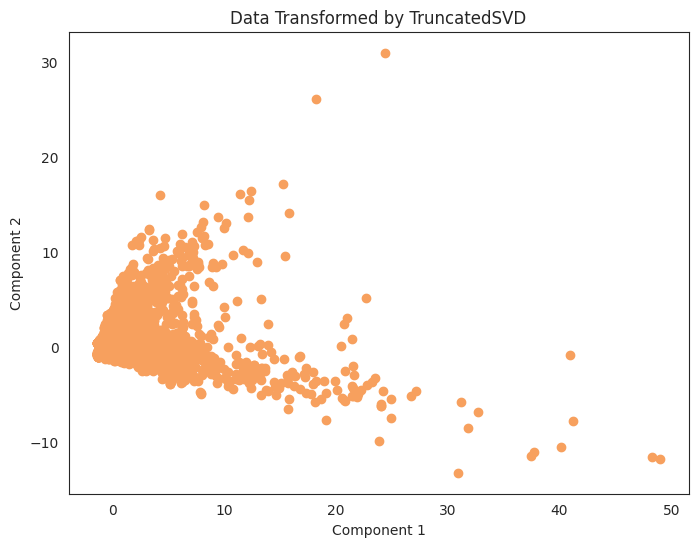

In [44]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Assuming 'prep_pipeline' is your preprocessing pipeline
x_train_transformed = prep_pipeline.fit_transform(nyc_copy)
# Initialize TruncatedSVD with the desired number of components
num_components = 10
svd = TruncatedSVD(n_components=num_components)

# Transform your sparse data using TruncatedSVD
x_svd = svd.fit_transform(x_train_transformed)

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x_svd[:, 0], x_svd[:, 1])  # Plotting two of the principal components
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Data Transformed by TruncatedSVD')
plt.show()

- The metrics we used to measure performance are **R-square** and **Mean Squared Errors**. We've decided to use these due to the continuous nature of the target variable `SALE_PRICE` . We've chosen R-square to showcase the goodness of fit, and MSE to showcase the penalty for far-off predictions.

### Ridge Regression

In [45]:
from sklearn.linear_model import Ridge

rdg_pipeline = Pipeline([
    ('data_processing', prep_pipeline),
    ('rdg', Ridge(random_state = 42)),
])

rdg_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127be20>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127bc40>)],
                                   verbose_feature_names_out=False)),
                ('rdg', Ridge(random_state=42))])

In [46]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {'rdg__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search_rdg = GridSearchCV(rdg_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score = 'raise')

grid_search_rdg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('data_processing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127be20>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a170127bc40>)],
                                                          verbose_feature_names_out=False)),
                                       ('rdg', Ridge(random_state=42))]),
             param_grid={'rdg__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                        100, 1000, 10000]},
             scoring='neg_mean_squared_error')

In [47]:
print('\n\nThe best parameters are ', grid_search_rdg.best_params_)

grid_cv_res = pd.DataFrame(grid_search_rdg.cv_results_) # convert to DF for convenience
grid_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)  # sort the data frame
# select only the columns that start with 'param_' and the column 'mean_test_score'
grid_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)



The best parameters are  {'rdg__alpha': 10}


,param_rdg__alpha,mean_test_score
6,10,-369645369953.25
5,1,-370267609481.07
4,0.10,-372112984010.86
3,0.01,-372543301297.35
0,0.00,-372579539459.08
2,0.00,-372589488721.41
1,0.00,-372595397722.93
7,100,-379293260575.82
8,1000,-415539261101.92
9,10000,-480816186259.61


In [48]:
# Assuming num_attribs is a list or array containing numerical attribute names
num_attribs_copy = num_attribs.copy()
# Assuming num_attribs_copy is a list
num_attribs_copy

['RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT']

In [59]:
# Feature importance analysis
num_feature_names = prep_pipeline.transformers_[0][1]['scaler'].get_feature_names_out(input_features=num_attribs)
cat_feature_names = prep_pipeline.transformers_[1][1]['cat_encoder'].get_feature_names_out(input_features=cat_attribs)

feature_names = np.concatenate([num_feature_names, cat_feature_names])

coefficients = grid_search_rdg.best_estimator_.named_steps['rdg'].coef_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

ValueError: ignored

In [ ]:
# Visualize coefficients
feature_importance_sorted = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)
top_coefficients = feature_importance_sorted.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_coefficients['Feature'], top_coefficients['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Regression Coefficients')
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = grid_search_rdg.predict(X_test)

# Compute R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Compute RMSE
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### KNN

NOTE: There is no specific way to measure feature importance for KNN models.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline([
    ('data_processing', prep_pipeline),
    ('knn', KNeighborsRegressor()),
])

knn_pipeline

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'knn__n_neighbors': randint(1, 20),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'knn__leaf_size': randint(10, 50),
    'knn__p': [1, 2]
}

# Perform Randomized Search Cross Validation
random_search_knn = RandomizedSearchCV(knn_pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error')
random_search_knn.fit(X_train, y_train)

In [ ]:
print('\n\nThe best parameters are ', random_search_knn.best_params_)

random_cv_res = pd.DataFrame(random_search_knn.cv_results_) # convert to DF for convenience
random_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)  # sort the data frame
# select only the columns that start with 'param_' and the column 'mean_test_score'
random_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

In [ ]:
y_pred = random_search_knn.predict(X_test)

# Compute R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Compute RMSE
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### XGBoost

In [ ]:
import xgboost as xgb
xgb_pipeline = Pipeline([('prep_pipe', prep_pipeline),
                                        ('xgb', xgb.XGBRegressor())])
xgb_pipeline.fit(X_train, y_train)

In [ ]:
y_pred= xgb_pipeline.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

In [ ]:
transformed_feature_names = xgb_pipeline.named_steps['prep_pipe'].get_feature_names_out() # getting the transformed column names

feature_importance = pd.Series(
    xgb_pipeline.named_steps['xgb'].feature_importances_,
    index=transformed_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(5).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance From XGBoost Model')
plt.ylabel('Feature Importance');

- RandomSearch for XGBoost

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
param_dis= {
    'xgb__eta': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__n_estimators': randint(100, 1000)
}

random_search_xgb= RandomizedSearchCV(estimator= xgb_pipeline, param_distributions=param_dis,
                                                                         scoring='neg_mean_squared_error',
                                                                         cv=3, n_jobs= -1, n_iter= 50)

random_search_xgb.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

best_params = random_search_xgb.best_params_
best_estimator = random_search_xgb.best_estimator_

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('\n\nThe best parameters are ', best_params)
print(f'R2 Score: {r2}')
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline= Pipeline([('prep_pipe', prep_pipeline),
                          ('random_forest', RandomForestRegressor(random_state=42))])

rf_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred= rf_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

In [ ]:
transformed_feature_names = rf_pipeline.named_steps['prep_pipe'].get_feature_names_out() # getting the transformed column names

feature_importance = pd.Series(
    rf_pipeline.named_steps['random_forest'].feature_importances_,
    index=transformed_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(5).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance From Random Forest Model')
plt.ylabel('Feature Importance');

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'random_forest__n_estimators': randint(100,300),
    'random_forest__max_depth': randint (5,20),
    'random_forest__min_samples_split': randint(2, 20),}
random_search = RandomizedSearchCV(estimator=rf_pipeline,
                                   param_distributions=param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=3, n_jobs= -1, n_iter= 25)

In [ ]:
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('\n\nThe best parameters are ', best_params)

print(f'R2 Score: {r2}')
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### Ensemble Method (Stacking)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

estimators = [
     ('rdg', Ridge(alpha = 10)),
     ('knn', KNeighborsRegressor(n_neighbors = 17, weights = 'distance', leaf_size = 44, algorithm = 'ball_tree', p = 2)),
     ('xgb', xgb.XGBRegressor(eta = 0.012, max_depth = 9, n_estimators = 500)),
     ('random_forest', RandomForestRegressor(n_estimators = 116, max_depth = 17, min_samples_split = 18))
]

stacking_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(),
    cv=5
)

stacking_reg.fit(tr_X, tr_y)

In [ ]:
print(f'Stacking the five has accuracy of {stacking_reg.score(t_X, t_y):.4f}')

In [ ]:
y_pred = stacking_reg.predict(t_X)

# Compute R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Compute RMSE
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

## 6- Conclusion

The four models chosen to predict `SALE_PRICE` are **Ridge regression, K-nearest Neighbors, XGBoost, and Random Forest**. We've chosen these four models because they've generally seen higher R-square and lower MSE. Here is the breakdown of the individual model's performance:

**Ridge Regression**: as the most simple regression in the project, Ridge has an **R-square of 0.409 and MSE of 605k**. We've chosen to use L2 over L1 regression due to the nature of our features. When some columns combined, such as BOROUGH and YEAR_BUILT , could have multicollinearity that creates more impact on the prediction. Hence, Ridge's coefficient function could help us dedicate more weights to these features.

**KNeighbors Regressor**: KNN has a great performance of **0.497 R-square and 558k MSE**. We chose this model because it allows us to explore different cluster sizes of SALE_PRICE .  This is also easy to interpret as the cluster features are accessible.

**Random Forest**: Random Forest was selected because it works as a great method to reduce overfitting. After random search, it has a great performance of **0.522 R-square and 544k MSE**, which makes it the best-performing model for this dataset.

**XGBoost**: XGBoost was selected to replace SVR. Initially, we chose SVM Regressor as our fourth model due to its separation capability. However, the model severely underperformed, leading us to add in XGBoost as a substitution. XGB's capability in handling complex datasets, feature importance analysis, and mitigating overfitting through regularization techniques helps the model achieve an **0.520 R-square and 546k MSE**.

**Stacking**: after using ensemble methods such as stacking, the R-square was averaged out to **0.501, and MSE to 556k**. This could be due to the fact that models such as Ridge having a much lower performance, the training on these models likely lowered the prediction accuracy.

In conclusion, Random Forest was the best performing model for our dataset due to its flexibility.